In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, LeakyReLU, Dropout, Dense, ReLU, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError, mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from termcolor import colored
import tensorflow as tf
import keras

# CSCO

In [ ]:
df_csco = pd.read_csv("CSCO.csv")
df_csco

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-02-16,0.000000,0.079861,0.073785,0.077257,0.059806,940636800
1,1990-02-20,0.000000,0.079861,0.074653,0.079861,0.061822,151862400
2,1990-02-21,0.000000,0.078993,0.075521,0.078125,0.060478,70531200
3,1990-02-22,0.000000,0.081597,0.078993,0.078993,0.061150,45216000
4,1990-02-23,0.000000,0.079861,0.078125,0.078559,0.060814,44697600
...,...,...,...,...,...,...,...
7584,2020-03-26,37.970001,40.919998,37.369999,40.580002,40.580002,38473300
7585,2020-03-27,39.209999,40.150002,38.410000,38.820000,38.820000,31278600
7586,2020-03-30,39.450001,40.490002,38.959999,40.320000,40.320000,27120300
7587,2020-03-31,40.130001,40.419998,39.110001,39.310001,39.310001,26014200


# 1a. Data Exploration

In [ ]:
df_csco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7589 entries, 0 to 7588
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7589 non-null   object 
 1   Open       7589 non-null   float64
 2   High       7589 non-null   float64
 3   Low        7589 non-null   float64
 4   Close      7589 non-null   float64
 5   Adj Close  7589 non-null   float64
 6   Volume     7589 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 415.1+ KB


In [ ]:
df_csco["Date"] = pd.to_datetime(df_csco["Date"])
df_csco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7589 entries, 0 to 7588
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7589 non-null   datetime64[ns]
 1   Open       7589 non-null   float64       
 2   High       7589 non-null   float64       
 3   Low        7589 non-null   float64       
 4   Close      7589 non-null   float64       
 5   Adj Close  7589 non-null   float64       
 6   Volume     7589 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 415.1 KB


In [ ]:
df_csco = df_csco.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"])
df_csco.head()

,Date,Close
0,1990-02-16,0.077257
1,1990-02-20,0.079861
2,1990-02-21,0.078125
3,1990-02-22,0.078993
4,1990-02-23,0.078559


array([<Axes: xlabel='Date'>], dtype=object)

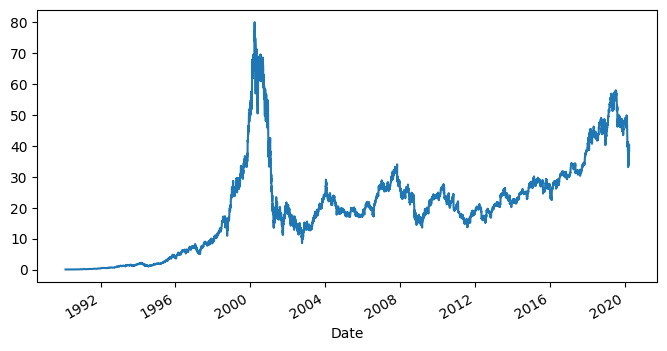

In [ ]:
df_csco.set_index('Date')["Close"].plot(subplots=True, figsize=(8,4))

## Splitting set

In [ ]:
def split_data(data):
    train_size = int(0.8 * len(data))
    val_size = int(0.1 * len(data))
    train, val, test = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]
    return train, val, test

In [ ]:
train_df_csco, val_df_csco, test_df_csco = split_data(df_csco)

train_df_csco

,Date,Close
0,1990-02-16,0.077257
1,1990-02-20,0.079861
2,1990-02-21,0.078125
3,1990-02-22,0.078993
4,1990-02-23,0.078559
...,...,...
6066,2014-03-17,21.510000
6067,2014-03-18,21.629999
6068,2014-03-19,21.629999
6069,2014-03-20,21.830000


In [ ]:
print(train_df_csco.shape)
print(val_df_csco.shape)
print(test_df_csco.shape)

(6071, 2)
(758, 2)
(760, 2)


## Scalling

In [ ]:
scaler = StandardScaler()
scaled_train_df_csco = scaler.fit_transform(train_df_csco.iloc[:,1].values.reshape(-1, 1))
scaled_val_df_csco = scaler.transform(val_df_csco.iloc[:,1].values.reshape(-1, 1))
scaled_test_df_csco = scaler.transform(test_df_csco.iloc[:,1].values.reshape(-1, 1))
scaled_train_df_csco

array([[-1.22432964],
       [-1.22413656],
       [-1.22426528],
       ...,
       [ 0.37364155],
       [ 0.38847007],
       [ 0.37438299]])

## Make dataset for each set
using generator

In [ ]:
window_size= 5
batch_size=32

train_generator = TimeseriesGenerator(scaled_train_df_csco, scaled_train_df_csco, length=window_size, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(scaled_val_df_csco, scaled_val_df_csco, length=window_size, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test_df_csco, scaled_test_df_csco, length=window_size, sampling_rate=1, batch_size=batch_size)

In [ ]:
train_generator[0]

(array([[[-1.22432964],
         [-1.22413656],
         [-1.22426528],
         [-1.22420092],
         [-1.2242331 ]],
 
        [[-1.22413656],
         [-1.22426528],
         [-1.22420092],
         [-1.2242331 ],
         [-1.224394  ]],
 
        [[-1.22426528],
         [-1.22420092],
         [-1.2242331 ],
         [-1.224394  ],
         [-1.22426528]],
 
        [[-1.22420092],
         [-1.2242331 ],
         [-1.224394  ],
         [-1.22426528],
         [-1.2240722 ]],
 
        [[-1.2242331 ],
         [-1.224394  ],
         [-1.22426528],
         [-1.2240722 ],
         [-1.22413656]],
 
        [[-1.224394  ],
         [-1.22426528],
         [-1.2240722 ],
         [-1.22413656],
         [-1.2240722 ]],
 
        [[-1.22426528],
         [-1.2240722 ],
         [-1.22413656],
         [-1.2240722 ],
         [-1.22413656]],
 
        [[-1.2240722 ],
         [-1.22413656],
         [-1.2240722 ],
         [-1.22413656],
         [-1.22413656]],
 
        [[-1.224

penjelasan:

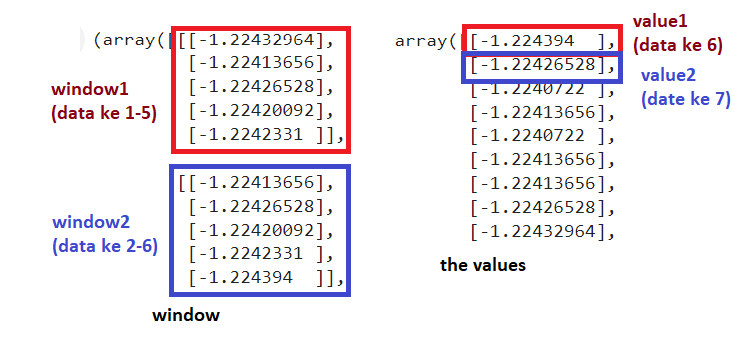

# Making Compiler and Evaluation Function

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def compiler(model):
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", verbose=1, restore_best_weights=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

    model_history = model.fit(train_generator, epochs=100,
                              validation_data=val_generator,
                              shuffle=False,
                              callbacks=[early_stopping])

    train_loss = model_history.history['loss']
    test_loss = model_history.history['val_loss']
    epoch_count = range(1, len(train_loss) + 1)

    return train_loss, test_loss, epoch_count

In [ ]:
def graph_loss(model,train_loss,test_loss,epoch_count):
    plt.plot(epoch_count, train_loss, 'b', label="train_loss")
    plt.plot(epoch_count, test_loss, 'r', label="test_loss")
    plt.title(f"Loss graph of {model_name}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def report(model, test_df):
  y_pred=model.predict(test_generator)
  ypred_rev_trans=scaler.inverse_transform(y_pred)

  data_windows = test_df.iloc[window_size:,:2].reset_index(drop=True)
  df_pred=pd.concat([data_windows, pd.DataFrame(ypred_rev_trans, columns=["prediction"])],axis=1)

  mae = print(f"MAE: {mean_absolute_error(data_windows.iloc[:,1], ypred_rev_trans)}")
  rmse = print(f"The RMSE is: {np.sqrt(mean_absolute_error(data_windows.iloc[:,1], ypred_rev_trans))}")

  actual = np.array(data_windows.iloc[:, 1])
  predictions = ypred_rev_trans.flatten()
  MAPE = mean_absolute_percentage_error(actual, predictions)
  mape = print(f"MAPE: {MAPE}")

  return df_pred, mae, rmse, mape

In [ ]:
def graph_result(model_name, df_pred):
  plt.title(f"The prediction graph of {model_name}")
  sns.lineplot(data=df_pred, x="Date", y=df_pred["Close"], label="actual")
  sns.lineplot(data=df_pred, x="Date",y=df_pred["prediction"],label="prediction", alpha=0.6)
  plt.xlabel("Time")
  plt.ylabel("Nilai Saham")

## 1b. model1 (the exam requirement)

In [ ]:
model1 = Sequential()
model1.add(LSTM(50, activation='relu', input_shape=(window_size, 1), return_sequences=False))
model1.add(Dense(1))

model_name = "model1"
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


restoring best weight agar run selanjutnya dimulai dari epoch yang dicap, bukan dari awal lagi

In [ ]:
train_loss1, test_loss1, epoch_count1 = compiler(model1)

model1.save('/content/drive/MyDrive/saved_models/model1_Q1_UAS.hdf5')

Epoch 1/100
190/190 [==============================] - 3s 6ms/step - loss: 0.9271 - val_loss: 0.6090
Epoch 2/100
190/190 [==============================] - 1s 5ms/step - loss: 0.8047 - val_loss: 0.5597
Epoch 3/100
190/190 [==============================] - 1s 5ms/step - loss: 0.6448 - val_loss: 0.5080
Epoch 4/100
190/190 [==============================] - 1s 5ms/step - loss: 0.4817 - val_loss: 0.4515
Epoch 5/100
190/190 [==============================] - 1s 5ms/step - loss: 0.3830 - val_loss: 0.3905
Epoch 6/100
190/190 [==============================] - 1s 5ms/step - loss: 0.3280 - val_loss: 0.3281
Epoch 7/100
190/190 [==============================] - 1s 5ms/step - loss: 0.2699 - val_loss: 0.2650
Epoch 8/100
190/190 [==============================] - 1s 7ms/step - loss: 0.2069 - val_loss: 0.2025
Epoch 9/100
190/190 [==============================] - 2s 8ms/step - loss: 0.1408 - val_loss: 0.1433
Epoch 10/100
190/190 [==============================] - 2s 10ms/step - loss: 0.0788 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


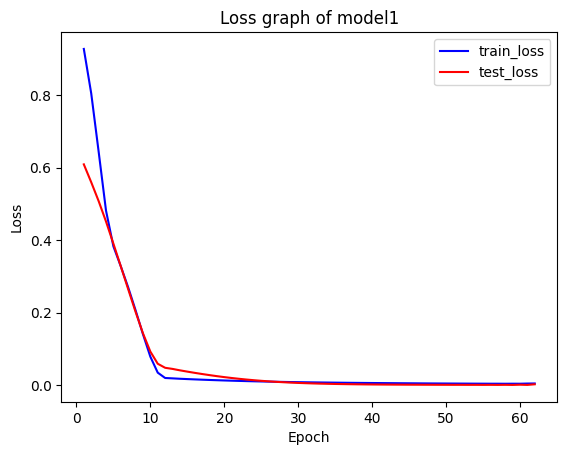

In [ ]:
graph_loss(model1,train_loss1,test_loss1,epoch_count1)

In [ ]:
model1.evaluate_generator(test_generator, verbose=0)

<ipython-input-57-ed86ad127d4c>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model1.evaluate_generator(test_generator, verbose=0)


0.006249041762202978

In [ ]:
df_pred1, mae1, rmse1, mape1= report(model1, test_df_csco)
df_pred1

24/24 [==============================] - 0s 3ms/step
MAE: 0.8242891122173788
The RMSE is: 0.9079036910473373
MAPE: 1.858734130859375


,Date,Close,prediction
0,2017-04-03,33.580002,33.600243
1,2017-04-04,33.410000,33.520046
2,2017-04-05,33.000000,33.366123
3,2017-04-06,33.080002,33.139050
4,2017-04-07,32.959999,32.999825
...,...,...,...
750,2020-03-26,40.580002,36.876583
751,2020-03-27,38.820000,37.976246
752,2020-03-30,40.320000,38.004295
753,2020-03-31,39.310001,39.027264


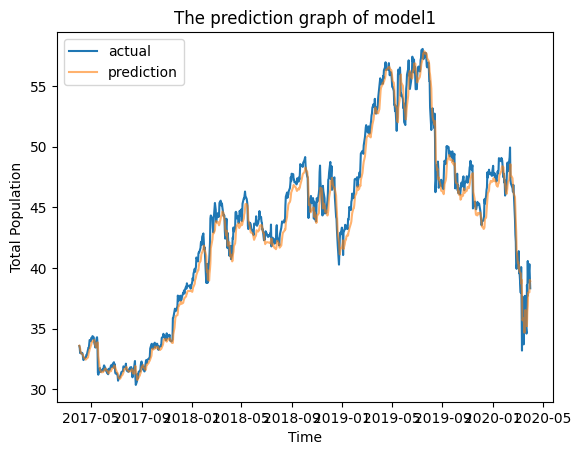

In [ ]:
graph_result(model_name, df_pred1)

## 1c. Modifikasi
dengan menambahkan bidirectional

In [ ]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(50, activation='relu', input_shape=(window_size, 1), return_sequences=False)))
model2.add(Dense(1))

model_name = "model2"

In [ ]:
train_loss2, test_loss2, epoch_count2 = compiler(model2)

Epoch 1/100
190/190 [==============================] - 7s 10ms/step - loss: 0.8854 - val_loss: 0.5766
Epoch 2/100
190/190 [==============================] - 1s 7ms/step - loss: 0.7090 - val_loss: 0.4684
Epoch 3/100
190/190 [==============================] - 1s 8ms/step - loss: 0.5207 - val_loss: 0.3586
Epoch 4/100
190/190 [==============================] - 1s 8ms/step - loss: 0.3533 - val_loss: 0.2435
Epoch 5/100
190/190 [==============================] - 2s 12ms/step - loss: 0.2331 - val_loss: 0.1365
Epoch 6/100
190/190 [==============================] - 3s 13ms/step - loss: 0.1370 - val_loss: 0.0558
Epoch 7/100
190/190 [==============================] - 2s 9ms/step - loss: 0.0566 - val_loss: 0.0146
Epoch 8/100
190/190 [==============================] - 1s 8ms/step - loss: 0.0130 - val_loss: 0.0057
Epoch 9/100
190/190 [==============================] - 2s 8ms/step - loss: 0.0079 - val_loss: 0.0066
Epoch 10/100
190/190 [==============================] - 2s 8ms/step - loss: 0.0074 - val

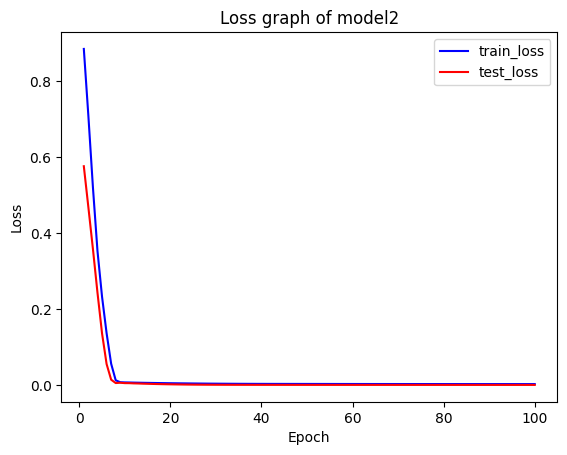

In [ ]:
graph_loss(model2,train_loss2,test_loss2,epoch_count2)

In [ ]:
model2.evaluate_generator(test_generator, verbose=0)

<ipython-input-102-bcd900a5a8d8>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model2.evaluate_generator(test_generator, verbose=0)


0.005692142061889172

In [ ]:
df_pred2, mae2, rmse2, mape2= report(model2, test_df_csco)
df_pred2

24/24 [==============================] - 0s 3ms/step
MAE: 0.7074961731765442
The RMSE is: 0.8411279172495372
MAPE: 1.5987260341644287


,Date,Close,prediction
0,2017-04-03,33.580002,33.851379
1,2017-04-04,33.410000,33.771526
2,2017-04-05,33.000000,33.620533
3,2017-04-06,33.080002,33.417812
4,2017-04-07,32.959999,33.302124
...,...,...,...
750,2020-03-26,40.580002,37.167236
751,2020-03-27,38.820000,38.017357
752,2020-03-30,40.320000,38.116825
753,2020-03-31,39.310001,39.266090


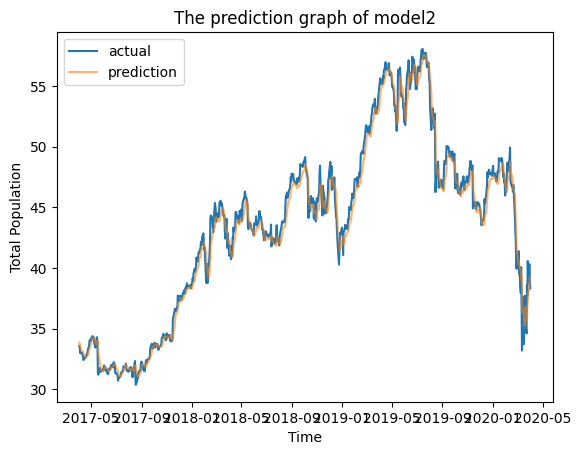

In [ ]:
graph_result(model_name, df_pred2)

# Kesimpulan data ke-1 (CSCO):


*   kedua model memberikan performa yang baik, ditandai dengan rendahnya nilai error pada ketiga metrik evaluasi dan prediction graph yang overlapping antara actual line dan prediction line, hal ini menandakan bahwa model belajar dengan baik dan memberi hasil akurasi yang tinggi pada testing

* model2 hasil modifikasi dengan bidirectional adalah yang terbaik dengan hasil evaluasi error yang lebih rendah dari model1.

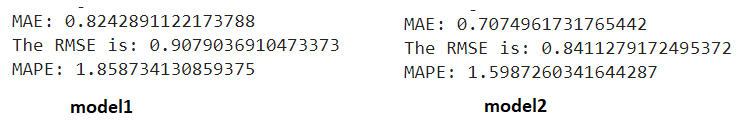



penjelasan model terbaik (model2):

1. MAE (Mean Absolute Error): Metrik ini menunjukkan rata-rata kesalahan absolut antara harga saham aktual dan harga yang diprediksi. MAE sebesar 0.707 menunjukkan bahwa, rata-rata, prediksi model meleset sebesar 0.707 satuan harga saham(dollar).

2. RMSE (Root Mean Squared Error): Metrik ini mengukur akar dari rata-rata kuadrat kesalahan. RMSE sebesar 0.841 menunjukkan bahwa secara keseluruhan, prediksi model cukup dekat dengan nilai aktual, tetapi ada beberapa kesalahan yang signifikan.

3. MAPE (Mean Absolute Percentage Error): Metrik ini menunjukkan kesalahan absolut rata-rata dalam bentuk persentase. MAPE sebesar 1.598 menunjukkan bahwa, rata-rata prediksi model meleset sekitar 1.6% dari nilai aktual.

Secara keseluruhan, hasil ini menunjukkan bahwa model2 cukup akurat dalam memprediksi harga saham, dengan kesalahan rata-rata kurang dari 1 unit harga saham dan kesalahan persentase sekitar 1.6%. Ini menandakan bahwa model2 dapat diandalkan untuk memprediksi pergerakan harga saham perusahaan



# AMZN

In [ ]:
df_amzn = pd.read_csv("AMZN.csv")
df_amzn

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
5753,2020-03-26,1902.000000,1956.489990,1889.290039,1955.489990,1955.489990,6221300
5754,2020-03-27,1930.859985,1939.790039,1899.920044,1900.099976,1900.099976,5387900
5755,2020-03-30,1922.829956,1973.630005,1912.339966,1963.949951,1963.949951,6126100
5756,2020-03-31,1964.349976,1993.020020,1944.010010,1949.719971,1949.719971,5123600


# 1. Data Exploration

In [ ]:
df_amzn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5758 non-null   object 
 1   Open       5758 non-null   float64
 2   High       5758 non-null   float64
 3   Low        5758 non-null   float64
 4   Close      5758 non-null   float64
 5   Adj Close  5758 non-null   float64
 6   Volume     5758 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 315.0+ KB


In [ ]:
df_amzn["Date"] = pd.to_datetime(df_amzn["Date"])
df_amzn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5758 non-null   datetime64[ns]
 1   Open       5758 non-null   float64       
 2   High       5758 non-null   float64       
 3   Low        5758 non-null   float64       
 4   Close      5758 non-null   float64       
 5   Adj Close  5758 non-null   float64       
 6   Volume     5758 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 315.0 KB


In [ ]:
df_amzn = df_amzn.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"])
df_amzn.head()

,Date,Close
0,1997-05-15,1.958333
1,1997-05-16,1.729167
2,1997-05-19,1.708333
3,1997-05-20,1.635417
4,1997-05-21,1.427083


array([<Axes: xlabel='Date'>], dtype=object)

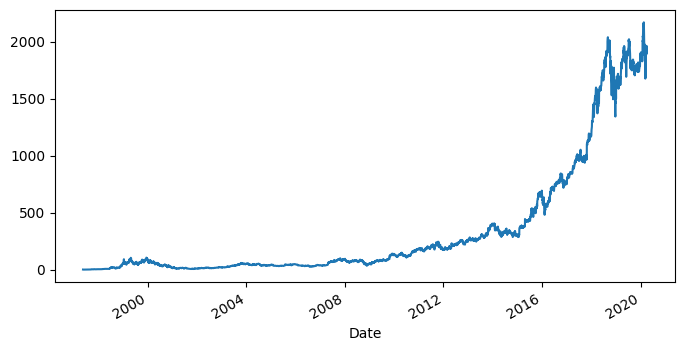

In [ ]:
df_amzn.set_index('Date')["Close"].plot(subplots=True, figsize=(8,4))

## Splitting set

In [ ]:
train_df_amzn, val_df_amzn, test_df_amzn = split_data(df_amzn)

train_df_amzn

,Date,Close
0,1997-05-15,1.958333
1,1997-05-16,1.729167
2,1997-05-19,1.708333
3,1997-05-20,1.635417
4,1997-05-21,1.427083
...,...,...
4601,2015-08-27,518.369995
4602,2015-08-28,518.010010
4603,2015-08-31,512.890015
4604,2015-09-01,496.540009


In [ ]:
print(train_df_amzn.shape)
print(val_df_amzn.shape)
print(test_df_amzn.shape)

(4606, 2)
(575, 2)
(577, 2)


## Scalling

In [ ]:
scaler = StandardScaler()
scaled_train_df_amzn = scaler.fit_transform(train_df_amzn.iloc[:,1].values.reshape(-1, 1))
scaled_val_df_amzn = scaler.transform(val_df_amzn.iloc[:,1].values.reshape(-1, 1))
scaled_test_df_amzn = scaler.transform(test_df_amzn.iloc[:,1].values.reshape(-1, 1))
scaled_train_df_amzn

array([[-0.93961361],
       [-0.94161055],
       [-0.94179209],
       ...,
       [ 3.51259311],
       [ 3.37012082],
       [ 3.49220236]])

## Make dataset for each set
using generator

In [ ]:
window_size= 5
batch_size=16

train_generator = TimeseriesGenerator(scaled_train_df_amzn, scaled_train_df_amzn, length=window_size, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(scaled_val_df_amzn, scaled_val_df_amzn, length=window_size, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test_df_amzn, scaled_test_df_amzn, length=window_size, sampling_rate=1, batch_size=batch_size)

In [ ]:
train_generator[0]

(array([[[-0.93961361],
         [-0.94161055],
         [-0.94179209],
         [-0.94242748],
         [-0.94424287]],
 
        [[-0.94161055],
         [-0.94179209],
         [-0.94242748],
         [-0.94424287],
         [-0.94451518]],
 
        [[-0.94179209],
         [-0.94242748],
         [-0.94424287],
         [-0.94451518],
         [-0.94360748]],
 
        [[-0.94242748],
         [-0.94424287],
         [-0.94451518],
         [-0.94360748],
         [-0.94288132]],
 
        [[-0.94424287],
         [-0.94451518],
         [-0.94360748],
         [-0.94288132],
         [-0.94333517]],
 
        [[-0.94451518],
         [-0.94360748],
         [-0.94288132],
         [-0.94333517],
         [-0.9435621 ]],
 
        [[-0.94360748],
         [-0.94288132],
         [-0.94333517],
         [-0.9435621 ],
         [-0.94360748]],
 
        [[-0.94288132],
         [-0.94333517],
         [-0.9435621 ],
         [-0.94360748],
         [-0.94351671]],
 
        [[-0.943

# 1b. model1 (the exam requirement)

In [ ]:
model1 = Sequential()
model1.add(LSTM(50, activation='relu', input_shape=(window_size, 1), return_sequences=False))
model1.add(Dense(1))

model_name = "model1"
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_loss1, test_loss1, epoch_count1 = compiler(model1)

Epoch 1/100
288/288 [==============================] - 4s 8ms/step - loss: 0.0989 - val_loss: 60.2038
Epoch 2/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0348 - val_loss: 55.2382
Epoch 3/100
288/288 [==============================] - 2s 5ms/step - loss: 0.0150 - val_loss: 44.7364
Epoch 4/100
288/288 [==============================] - 2s 5ms/step - loss: 0.0119 - val_loss: 37.0771
Epoch 5/100
288/288 [==============================] - 2s 5ms/step - loss: 0.0100 - val_loss: 30.9691
Epoch 6/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0085 - val_loss: 25.8810
Epoch 7/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0074 - val_loss: 21.6731
Epoch 8/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0065 - val_loss: 18.1636
Epoch 9/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0057 - val_loss: 15.2488
Epoch 10/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0051

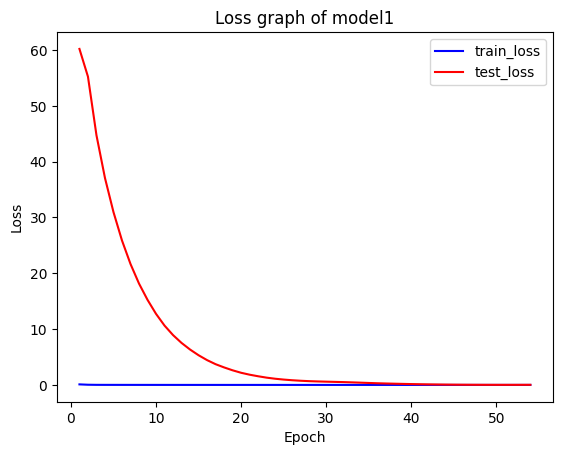

In [ ]:
graph_loss(model1,train_loss1,test_loss1,epoch_count1)

In [ ]:
model1.evaluate_generator(test_generator, verbose=0)

<ipython-input-23-ed86ad127d4c>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model1.evaluate_generator(test_generator, verbose=0)


2.724829912185669

In [ ]:
df_pred1, mae1, rmse1, mape1= report(model1, test_df_amzn)
df_pred1

36/36 [==============================] - 0s 3ms/step
MAE: 175.87541230741914
The RMSE is: 13.261802754807475
MAPE: 9.823598861694336


,Date,Close,prediction
0,2017-12-21,1174.760010,1159.449707
1,2017-12-22,1168.359985,1155.520996
2,2017-12-26,1176.760010,1151.220459
3,2017-12-27,1182.260010,1155.140259
4,2017-12-28,1186.099976,1160.648438
...,...,...,...
567,2020-03-26,1955.489990,1670.472412
568,2020-03-27,1900.099976,1684.334351
569,2020-03-30,1963.949951,1678.793335
570,2020-03-31,1949.719971,1689.789551


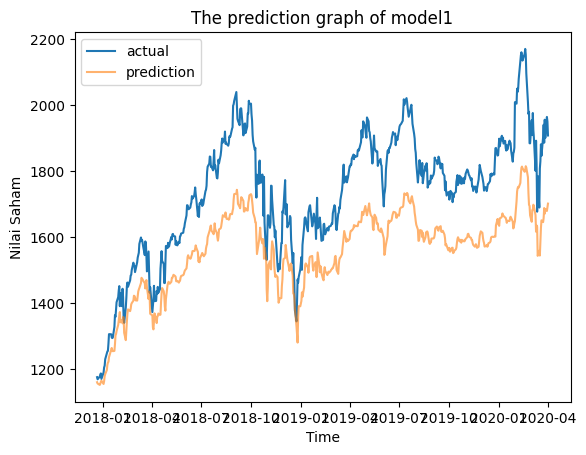

In [ ]:
graph_result(model_name, df_pred1)

# 1c. Modifikasi
dengan menambahkan bidirectional dan layer LSTM kedua dan layer drop-out

In [ ]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(100, activation='relu', input_shape=(window_size, 1), return_sequences=True)))
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(50, activation='relu', return_sequences=False)))
model2.add(Dropout(0.1))
model2.add(Dense(1))

model_name = "model2"

In [ ]:
train_loss2, test_loss2, epoch_count2 = compiler(model2)

Epoch 1/100
288/288 [==============================] - 13s 19ms/step - loss: 0.2595 - val_loss: 49.9704
Epoch 2/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0445 - val_loss: 27.3386
Epoch 3/100
288/288 [==============================] - 5s 17ms/step - loss: 0.0303 - val_loss: 14.7263
Epoch 4/100
288/288 [==============================] - 5s 18ms/step - loss: 0.0161 - val_loss: 7.0423
Epoch 5/100
288/288 [==============================] - 6s 21ms/step - loss: 0.0118 - val_loss: 4.1019
Epoch 6/100
288/288 [==============================] - 5s 16ms/step - loss: 0.0106 - val_loss: 2.6903
Epoch 7/100
288/288 [==============================] - 6s 21ms/step - loss: 0.0089 - val_loss: 1.3977
Epoch 8/100
288/288 [==============================] - 5s 16ms/step - loss: 0.0088 - val_loss: 1.3239
Epoch 9/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0082 - val_loss: 1.6347
Epoch 10/100
288/288 [==============================] - 5s 17ms/step - loss: 0

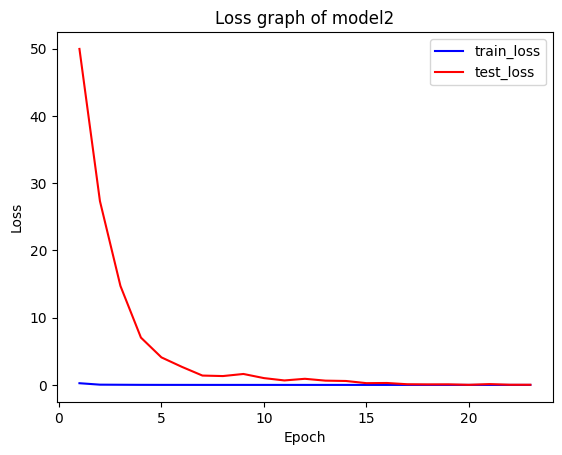

In [ ]:
graph_loss(model2,train_loss2,test_loss2,epoch_count2)

In [ ]:
model2.evaluate_generator(test_generator, verbose=0)

<ipython-input-46-bcd900a5a8d8>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model2.evaluate_generator(test_generator, verbose=0)


0.12466344237327576

In [ ]:
df_pred2, mae2, rmse2, mape2= report(model2, test_df_amzn)
df_pred2

36/36 [==============================] - 1s 6ms/step
MAE: 29.27832863547585
The RMSE is: 5.41094526265752
MAPE: 1.7217774391174316


,Date,Close,prediction
0,2017-12-21,1174.760010,1197.190308
1,2017-12-22,1168.359985,1196.071777
2,2017-12-26,1176.760010,1192.992676
3,2017-12-27,1182.260010,1192.994507
4,2017-12-28,1186.099976,1194.139160
...,...,...,...
567,2020-03-26,1955.489990,1907.401123
568,2020-03-27,1900.099976,1934.541626
569,2020-03-30,1963.949951,1927.303955
570,2020-03-31,1949.719971,1951.982422


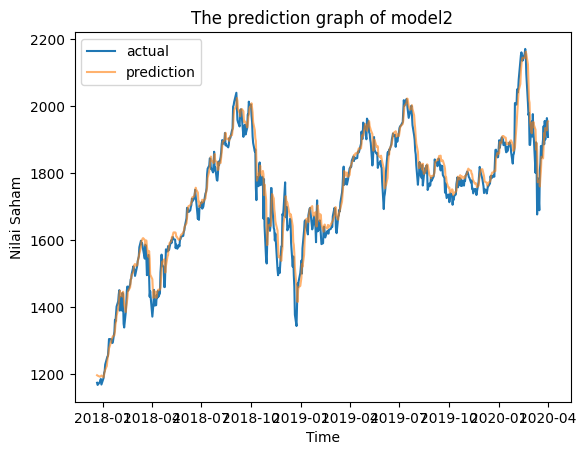

In [ ]:
graph_result(model_name, df_pred2)

## Kesimpulan data ke-2 (AMZN)

* model1 memberi performa yang buruk dengan nilai error yang tinggi dan garis prediksi yang jauh melenceng dari garis aktual. Berdasarkan history dan graph model1 juga menandakan indikasi underfit

* Sebaliknya, Model 2 lebih unggul dibandingkan Model 1 berdasarkan ketiga metrik evaluasi yang jauh lebih rendah, menunjukkan bahwa prediksinya lebih mendekati nilai aktual, memiliki distribusi kesalahan yang lebih sempit, dan persentase kesalahan yang lebih kecil terhadap nilai aktual.

* Berdasarkan asumsi performa model1, maka dari itu dengan ditambahnya layer tambahan dengan bidirectional, jumlah neuron dan drop-out layer berhasil mengatasi permasalahan underfit dan model2 dapat memberi peningkatan performa dan nilai error yang lebih rendah

Penjelasan model terbaik (model2):
1. MAE mengukur rata-rata kesalahan absolut antara prediksi dan nilai aktual. Dalam kasus ini, rata-rata kesalahan prediksi harga saham adalah sekitar 29.28 unit (dollar, misalnya).
2. RMSE mengukur akar kuadrat dari rata-rata kesalahan kuadrat. RMSE cenderung memberikan penalti lebih besar untuk kesalahan yang lebih besar. Dalam hal ini, RMSE sebesar 5.41 menunjukkan bahwa secara keseluruhan, prediksi model cukup dekat dengan nilai aktual, tetapi ada beberapa kesalahan yang signifikan.
3. MAPE mengukur rata-rata kesalahan absolut dalam bentuk persentase dari nilai aktual. Nilai 1.72% berarti bahwa rata-rata kesalahan prediksi model adalah sekitar 1.72% dari harga aktual saham.

Model2 memiliki performa yang cukup baik dalam memprediksi harga saham perusahaan lain dengan tingkat kesalahan yang relatif kecil. Namun, nilai MAE yang cukup tinggi menunjukkan bahwa mungkin diperlukan perbaikan, terutama jika prediksi harga dalam unit yang lebih kecil dianggap lebih penting.

# Case 2

In [ ]:
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D
import idx2numpy

## 1a. loading and scaling data

In [ ]:
train_images = idx2numpy.convert_from_file('train-images-idx3-ubyte')
test_images = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')
train_labels = idx2numpy.convert_from_file('train-labels-idx1-ubyte')
test_labels = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte')

print(f'Train images shape: {train_images.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train images shape: (60000, 28, 28)
Test images shape: (10000, 28, 28)
Train labels shape: (60000,)
Test labels shape: (10000,)


## selecting the data to compute
label2 = pullover, label3 = dress

In [ ]:
train_selected = (train_labels == 2) | (train_labels == 3)
test_selected = (test_labels == 2) | (test_labels == 3)

x_train_selected = train_images[train_selected]
y_train_selected = train_labels[train_selected]
x_test_selected = test_images[test_selected]
y_test_selected = test_labels[test_selected]

#scalling the images
x_train_selected = x_train_selected.astype('float32') / 255
x_test_selected = x_test_selected.astype('float32') / 255

print(f'x_train shape: {x_train_selected.shape}')
print(f'y_train shape: {y_train_selected.shape}')
print(f'x_test shape: {x_test_selected.shape}')
print(f'y_test shape: {y_test_selected.shape}')

x_train shape: (12000, 28, 28)
y_train shape: (12000,)
x_test shape: (2000, 28, 28)
y_test shape: (2000,)


## splitting sets

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_selected, y_train_selected, test_size=0.2, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=0)

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'x_test shape: {x_test.shape}')

x_train shape: (9600, 28, 28)
y_train shape: (9600,)
x_val shape: (1200, 28, 28)
x_test shape: (1200, 28, 28)


## display images

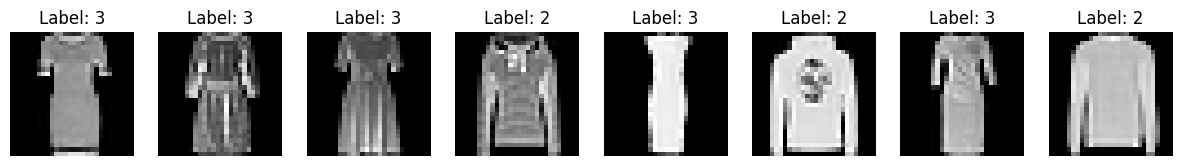

In [ ]:
fig, axes = plt.subplots(1, 8, figsize=(15, 2))
for i in range(8):
    ax = axes[i]
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.show()

# Building Models
## 1b. model1 (exam requirement)

In [ ]:
# Encoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(128, activation='relu')(x)

# Decoder
x = Dense(6272, activation='relu')(encoded)
x = Reshape((14, 14, 32))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", verbose=1, restore_best_weights=True)

# Train the model
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[early_stopping])

# Predict on test data
decoded_imgs = autoencoder.predict(x_test)

Epoch 1/50
150/150 [==============================] - 33s 212ms/step - loss: 0.3707 - val_loss: 0.3233
Epoch 2/50
150/150 [==============================] - 30s 201ms/step - loss: 0.3080 - val_loss: 0.3044
Epoch 3/50
150/150 [==============================] - 31s 205ms/step - loss: 0.2960 - val_loss: 0.2968
Epoch 4/50
150/150 [==============================] - 30s 198ms/step - loss: 0.2906 - val_loss: 0.2932
Epoch 5/50
150/150 [==============================] - 30s 203ms/step - loss: 0.2877 - val_loss: 0.2905
Epoch 6/50
150/150 [==============================] - 31s 206ms/step - loss: 0.2855 - val_loss: 0.2891
Epoch 7/50
150/150 [==============================] - 31s 206ms/step - loss: 0.2839 - val_loss: 0.2879
Epoch 8/50
150/150 [==============================] - 32s 213ms/step - loss: 0.2827 - val_loss: 0.2871
Epoch 9/50
150/150 [==============================] - 30s 203ms/step - loss: 0.2818 - val_loss: 0.2860
Epoch 10/50
150/150 [==============================] - 30s 200ms/step - l

In [ ]:
def evaluate_ssim(original, reconstructed):
    ssim_scores = []
    for i in range(len(original)):
        score = ssim(original[i].reshape(28, 28), reconstructed[i].reshape(28, 28))
        ssim_scores.append(score)
    return np.mean(ssim_scores)

ssim_score = evaluate_ssim(x_test, decoded_imgs)
print(f'Average SSIM: {ssim_score}')

Average SSIM: 0.8817642874243719


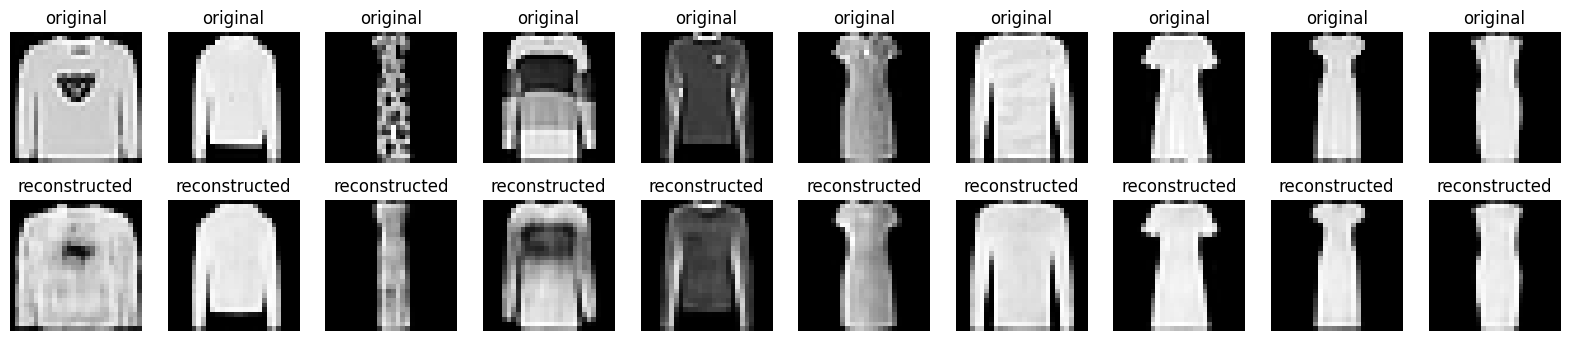

In [ ]:
def display_image(decoded_imgs):
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # Display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
      plt.title("original")
      plt.axis('off')

      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
      plt.title("reconstructed")
      plt.axis('off')
  plt.show()

display_image(decoded_imgs)

## 1c. modified models + tuning params
adding:
* 1 layer Conv2D, 1 layer MaxPooling2D, 1 layer Dense, 1 layer dropout
* add learning_rate

In [ ]:
def build_autoencoder(dense_neurons, dropout_rate):
    # Encoder
    input_img = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(dense_neurons, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    encoded = Dense(dense_neurons // 2, activation='relu')(x)

    # Decoder
    x = Dense(7*7*64, activation='relu')(encoded)
    x = Reshape((7, 7, 64))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = Model(input_img, decoded)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", verbose=1, restore_best_weights=True)

    # Train the mode
    autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[early_stopping])

    # Predict on test data
    decoded_imgs = autoencoder.predict(x_test)

    return decoded_imgs

## modified model
Menggunakan function yang sudah saya desain, parameter yang akan saya gunakan untuk model ini dipilih berdasarkan keyakinan saya yang dapat memberi performa terbaik

In [ ]:
decoded_imgs_modified = build_autoencoder(64, 0.2)

Epoch 1/50
150/150 [==============================] - 6s 10ms/step - loss: 0.3878 - val_loss: 0.3384
Epoch 2/50
150/150 [==============================] - 1s 8ms/step - loss: 0.3316 - val_loss: 0.3234
Epoch 3/50
150/150 [==============================] - 1s 7ms/step - loss: 0.3235 - val_loss: 0.3163
Epoch 4/50
150/150 [==============================] - 1s 8ms/step - loss: 0.3186 - val_loss: 0.3139
Epoch 5/50
150/150 [==============================] - 1s 7ms/step - loss: 0.3162 - val_loss: 0.3098
Epoch 6/50
150/150 [==============================] - 1s 8ms/step - loss: 0.3142 - val_loss: 0.3087
Epoch 7/50
150/150 [==============================] - 1s 9ms/step - loss: 0.3129 - val_loss: 0.3067
Epoch 8/50
150/150 [==============================] - 1s 8ms/step - loss: 0.3115 - val_loss: 0.3059
Epoch 9/50
150/150 [==============================] - 1s 7ms/step - loss: 0.3102 - val_loss: 0.3050
Epoch 10/50
150/150 [==============================] - 1s 7ms/step - loss: 0.3098 - val_loss: 0.304

In [ ]:
ssim_score = evaluate_ssim(x_test, decoded_imgs_modified)
print(f'Average SSIM: {ssim_score}')

Average SSIM: 0.7764901335276804


hasil yang didapat lebih rendah daripada model original

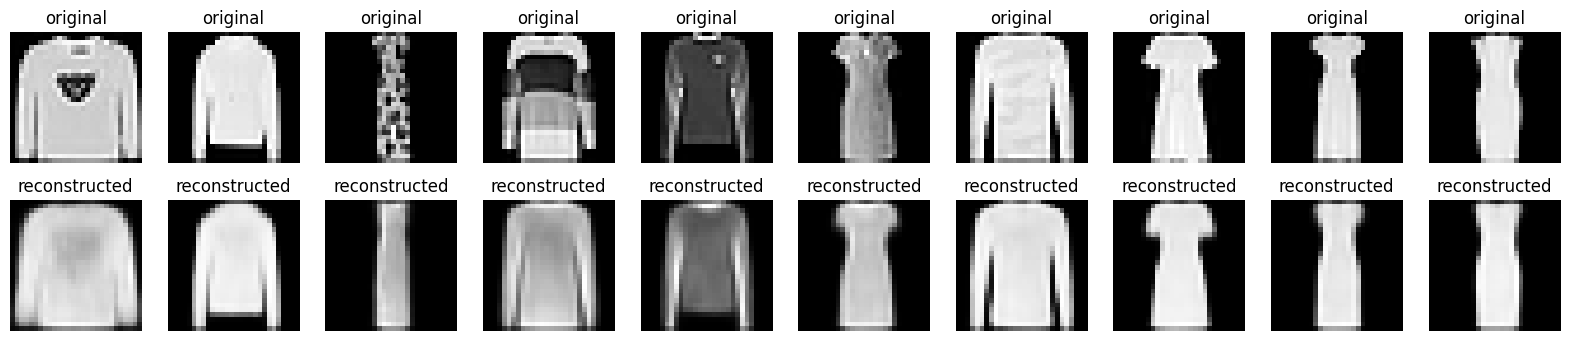

In [ ]:
display_image(decoded_imgs_modified)

## tuning params
Menggunkaan function yang sudah saya desain, saya akan melakukan tuning parameter jumlah neuron dan drop_out layer yang paling optimal dalam memberi nilai SSIM tertinggi

In [ ]:
# Hyperparameters to tune
# akan melakukan training sebanyak 3*3 = 9 model

dense_neurons_options = [128, 256, 512]
dropout_rate_options = [0.3, 0.5, 0.7]

best_ssim = 0
best_params = {'dense_neurons': None, 'dropout_rate': None}
best_model = None

for dense_neurons in dense_neurons_options:
    for dropout_rate in dropout_rate_options:
        print(f'Training with dense_neurons={dense_neurons}, dropout_rate={dropout_rate}')
        decoded_imgs_tuning = build_autoencoder(dense_neurons, dropout_rate)

        # Evaluate with SSIM
        ssim_score = evaluate_ssim(x_test, decoded_imgs_tuning)
        print(f'SSIM for dense_neurons={dense_neurons}, dropout_rate={dropout_rate}: {ssim_score}')

        if ssim_score > best_ssim:
            best_ssim = ssim_score
            best_params['dense_neurons'] = dense_neurons
            best_params['dropout_rate'] = dropout_rate

Training with dense_neurons=128, dropout_rate=0.3
Epoch 1/50
150/150 [==============================] - 4s 11ms/step - loss: 0.3747 - val_loss: 0.3330
Epoch 2/50
150/150 [==============================] - 1s 8ms/step - loss: 0.3258 - val_loss: 0.3187
Epoch 3/50
150/150 [==============================] - 1s 8ms/step - loss: 0.3173 - val_loss: 0.3108
Epoch 4/50
150/150 [==============================] - 1s 7ms/step - loss: 0.3139 - val_loss: 0.3076
Epoch 5/50
150/150 [==============================] - 1s 8ms/step - loss: 0.3107 - val_loss: 0.3061
Epoch 6/50
150/150 [==============================] - 1s 8ms/step - loss: 0.3089 - val_loss: 0.3041
Epoch 7/50
150/150 [==============================] - 1s 7ms/step - loss: 0.3077 - val_loss: 0.3021
Epoch 8/50
150/150 [==============================] - 1s 8ms/step - loss: 0.3061 - val_loss: 0.3010
Epoch 9/50
150/150 [==============================] - 1s 8ms/step - loss: 0.3053 - val_loss: 0.3011
Epoch 10/50
150/150 [============================

In [ ]:
print(f'Best SSIM: {best_ssim} with parameters: {best_params}')

Best SSIM: 0.8449689809423816 with parameters: {'dense_neurons': 512, 'dropout_rate': 0.3}


hasil yang didapat dari tuning parameter memberi nilai SSIM yang lebih tinggi daripada model_modified yang saya coba sebelumnya.

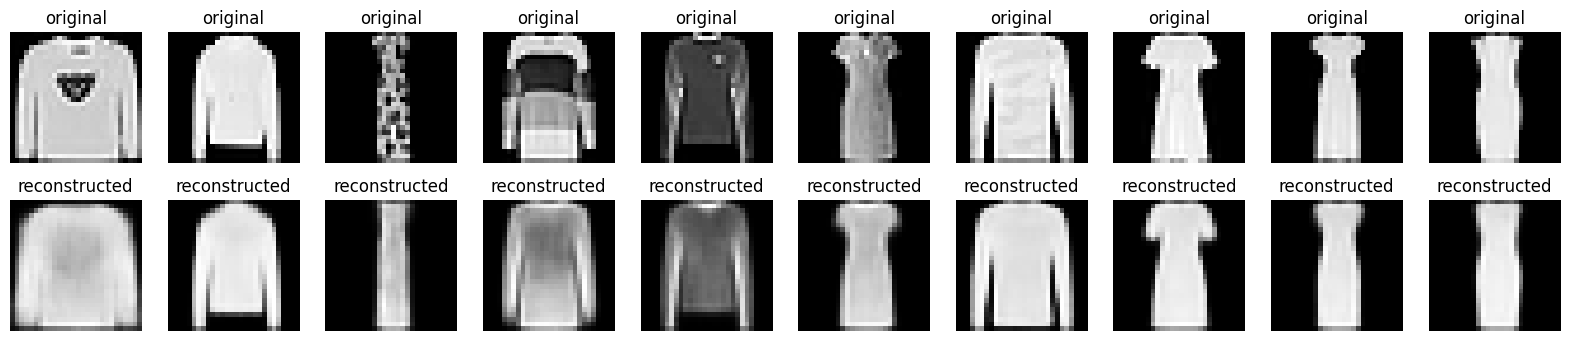

In [ ]:
display_image(decoded_imgs_tuning)

# Kesimpulan:

* berdasarkan ketiga model, model1 memberi performa terbaik yang ditandai dengan nilai SSIM yang paling tinggi yaitu 0.88. Nilai SSIM yang tinggi menunjukkan bahwa gambar rekontruksi sangat mirip dengan gambar asli
* Hasil SSIM dari auto-tuning dengan menggunakan arsitektur yang saya modifikasi sebesar 0.845 lebih rendah daripada model original, hal ini kemungkinan besar dikarenakan tambahan beberapa layer yang membebankan model sehingga memberi performa yang lebih buruk daripada model original dengan sedikit layer
* kemungkinan besar, jika saya melakukan tuning untuk arsitektur model original, performa yang dihasilkan akan jauh lebih tinggi dari SSIM 0.88

# Case 3

## 3a. Jelaskan cara kerja dari arsitektur tersebut yang dideskripsikan dalam gambar di bawah ini

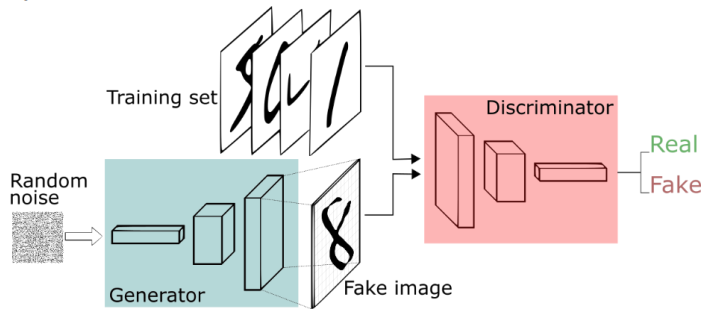

1. Generator:

* Generator mengambil input berupa random noise, dengan menggunakan random noise tersebut, generator menghasilkan gambar yang bertujuan untuk meniru gambar-gambar dalam set pelatihan.
* Proses ini dapat melibatkan beberapa lapisan neural network untuk secara bertahap mengubah noise menjadi gambar yang lebih realistis.

2. Discriminator:
* Discriminator menerima input berupa gambar dari set pelatihan (gambar asli) dan gambar yang dihasilkan oleh generator (gambar palsu).
* Selanjutnya discriminator akan mengklasifikasikan gambar tersebut sebagai "real" (asli) atau "fake" (palsu).

3. Proses Pelatihan:
* GAN dilatih melalui proses adversarial, di mana generator dan discriminator berkompetisi satu sama lain.
* Generator berusaha menjadi lebih baik dalam membuat gambar palsu yang tidak dapat dibedakan dari gambar asli oleh discriminator.
* Discriminator berusaha menjadi lebih baik dalam membedakan antara gambar asli dan gambar palsu.
Proses ini terjadi dalam dua tahap yang berulang:
  * Pelatihan Discriminator: Discriminator dilatih menggunakan gambar asli dari set pelatihan dan gambar palsu yang dihasilkan oleh generator. Tujuannya adalah meminimalkan kesalahan dalam klasifikasi gambar.
  * Pelatihan Generator: Generator dilatih untuk menghasilkan gambar yang dapat menipu discriminator agar menganggapnya sebagai gambar asli. Tujuannya adalah memaksimalkan kesalahan klasifikasi discriminator saat menerima gambar palsu.

4. Output Akhir:
Setelah banyak iterasi pelatihan, generator diharapkan mampu menghasilkan gambar yang sangat mirip dengan gambar dalam set pelatihan sehingga sulit bagi discriminator untuk membedakan gambar asli dan gambar palsu.

## 1b.  Buatlah arsitektur untuk image generation sesuai dengan gambar arsitektur GAN berikut ini. Lakukan evaluasi kesamaan distribusi citra dengan menggunakan Fréchet Inception Distance (FID) pada data test.
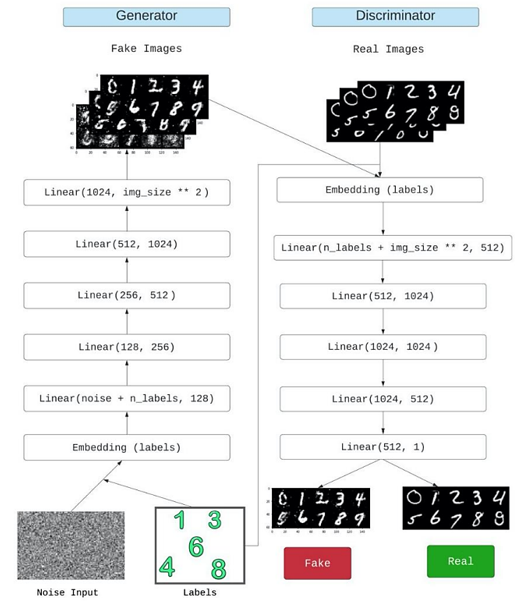

In [ ]:
from tensorflow.keras.layers import Dense, Reshape, Flatten, Embedding, Concatenate, Input
import tensorflow_gan as tfgan

In [ ]:
train_images = idx2numpy.convert_from_file('train-images-idx3-ubyte')
test_images = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')
train_labels = idx2numpy.convert_from_file('train-labels-idx1-ubyte')
test_labels = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte')

print(f'Train images shape: {train_images.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train images shape: (60000, 28, 28)
Test images shape: (10000, 28, 28)
Train labels shape: (60000,)
Test labels shape: (10000,)


In [ ]:
train_selected = (train_labels == 2) | (train_labels == 3)
test_selected = (test_labels == 2) | (test_labels == 3)

x_train_selected = train_images[train_selected]
y_train_selected = train_labels[train_selected]
x_test_selected = test_images[test_selected]
y_test_selected = test_labels[test_selected]

#scalling the images
x_train_selected = x_train_selected.astype('float32') / 255
x_test_selected = x_test_selected.astype('float32') / 255

print(f'x_train shape: {x_train_selected.shape}')
print(f'y_train shape: {y_train_selected.shape}')
print(f'x_test shape: {x_test_selected.shape}')
print(f'y_test shape: {y_test_selected.shape}')

x_train shape: (12000, 28, 28)
y_train shape: (12000,)
x_test shape: (2000, 28, 28)
y_test shape: (2000,)


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_selected, y_train_selected, test_size=0.2, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=0)

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'x_test shape: {x_test.shape}')

x_train shape: (9600, 28, 28)
y_train shape: (9600,)
x_val shape: (1200, 28, 28)
x_test shape: (1200, 28, 28)


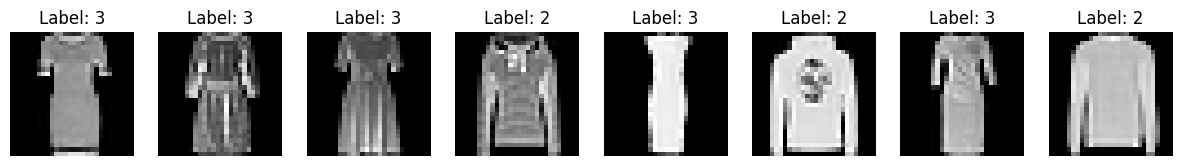

In [ ]:
fig, axes = plt.subplots(1, 8, figsize=(15, 2))
for i in range(8):
    ax = axes[i]
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.show()

## Define Generator & Discriminator

In [ ]:
img_shape = x_train.shape[1:]
num_classes = 2
noise_dim = 50

# Generator
def build_generator():
    noise = Input(shape=(noise_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, noise_dim)(label))
    model_input = tf.keras.layers.multiply([noise, label_embedding])

    x = Dense(128)(model_input)
    x = Dense(256)(x)
    x = Dense(512)(x)
    x = Dense(1024)(x)
    x = Dense(np.prod(img_shape), activation='tanh')(x)
    img_gen = Reshape(img_shape)(x)

    return Model([noise, label], img_gen)

# Discriminator
def build_discriminator():
    img_disc = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img_disc)
    model_input = Concatenate()([flat_img, label_embedding])

    x = Dense(512)(model_input)
    x = Dense(1024)(x)
    x = Dense(1024)(x)
    x = Dense(512)(x)
    validity = Dense(1, activation='sigmoid')(x)

    return Model([img_disc, label], validity)

generator = build_generator()
discriminator = build_discriminator()

In [ ]:
generator.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_85 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_27 (Embedding)    (None, 1, 50)                100       ['input_85[0][0]']            
                                                                                                  
 input_84 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 flatten_38 (Flatten)        (None, 50)                   0         ['embedding_27[0][0]']        
                                                                                           

In [ ]:
discriminator.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_87 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_86 (InputLayer)       [(None, 28, 28)]             0         []                            
                                                                                                  
 embedding_28 (Embedding)    (None, 1, 784)               1568      ['input_87[0][0]']            
                                                                                                  
 flatten_40 (Flatten)        (None, 784)                  0         ['input_86[0][0]']            
                                                                                           

In [ ]:
def build_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.00005, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    noise = Input(shape=(noise_dim,))
    label = Input(shape=(1,))
    img = generator([noise, label])
    valid = discriminator([img, label])

    gan = Model([noise, label], valid)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))

    return gan

gan = build_gan(generator, discriminator)
gan.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_80 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_81 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 model_29 (Functional)       (None, 28, 28)               1500148   ['input_80[0][0]',            
                                                                     'input_81[0][0]']            
                                                                                                  
 model_30 (Functional)       (None, 1)                    2905121   ['model_29[0][0]',     

In [ ]:
# Training the GAN
epochs = 3000
batch_size = 64
sample_interval = 100

half_batch = int(batch_size / 2)

for epoch in range(epochs):
    #  Train Discriminator
    idx = np.random.randint(0, x_train.shape[0], half_batch)
    imgs, labels = x_train[idx], y_train[idx]
    noise = np.random.normal(0, 1, (half_batch, noise_dim))
    gen_imgs = generator.predict([noise, labels])

    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))

    d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    #  Train Generator
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    valid = np.ones((batch_size, 1))
    sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
    g_loss = gan.train_on_batch([noise, sampled_labels], valid)

    # If at save interval => save generated image samples
    if epoch % sample_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")


1/1 [==============================] - 0s 123ms/step
0 [D loss: 0.6257887780666351 | D accuracy: 0.484375] [G loss: 0.6881021857261658]
1/1 [==============================] - 0s 18ms/step
100 [D loss: 0.035659406799823046 | D accuracy: 1.0] [G loss: 4.505832672119141]
1/1 [==============================] - 0s 18ms/step
200 [D loss: 0.125138271600008 | D accuracy: 0.96875] [G loss: 4.289974212646484]
1/1 [==============================] - 0s 22ms/step
300 [D loss: 0.17173396795988083 | D accuracy: 0.96875] [G loss: 4.632102012634277]
1/1 [==============================] - 0s 17ms/step
400 [D loss: 0.7833197712898254 | D accuracy: 0.40625] [G loss: 5.336551666259766]
1/1 [==============================] - 0s 22ms/step
500 [D loss: 0.8185776472091675 | D accuracy: 0.3125] [G loss: 4.44181489944458]
1/1 [==============================] - 0s 17ms/step
600 [D loss: 0.7644593715667725 | D accuracy: 0.28125] [G loss: 3.3712759017944336]
1/1 [==============================] - 0s 18ms/step
700 [

In [ ]:
from skimage.transform import resize
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
def scale_images(images):
    return images * 2.0 - 1.0

# Generate images
def generate_images(generator, n_samples, noise_dim, n_classes):
    noise = np.random.normal(0, 1, (n_samples, noise_dim))
    labels = np.random.randint(0, n_classes, n_samples)
    gen_imgs = generator.predict([noise, labels])
    return gen_imgs

# Calculate FID
def calculate_fid(model, images1, images2):
    # Rescale images to 3 channels (required for InceptionV3)
    images1 = np.array([resize(image, (299, 299, 3)) for image in images1])
    images2 = np.array([resize(image, (299, 299, 3)) for image in images2])

    # Preprocess images for InceptionV3
    images1 = tf.keras.applications.inception_v3.preprocess_input(images1)
    images2 = tf.keras.applications.inception_v3.preprocess_input(images2)

    act1 = model.predict(images1)
    act2 = model.predict(images2)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Load the InceptionV3 model
inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Generate images
real_images = scale_images(x_test)
gen_images = scale_images(generate_images(generator, x_test.shape[0], noise_dim, num_classes))

# Compute FID
fid = calculate_fid(inception_model, real_images, gen_images)
print(f"FID: {fid}")

38/38 [==============================] - 4s 107ms/step
FID: 2097158.9721832275
